In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import os

os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"

In [2]:
get_y_fn = lambda x: x.parents[0] / (x.stem + "_mask" + x.suffix)

In [3]:
data_path = Path(
    "/media/subhaditya/DATA/COSMO/Datasets/lgg-mri-segmentation/kaggle_3m/"
)
small_data_path = data_path / "TCGA_HT_7680_19970202"
# small_data_path.ls()

In [4]:
temp_img_file = small_data_path / "TCGA_HT_7680_19970202_6.tif"
temp_mask_file = get_y_fn(temp_img_file)

showing /media/subhaditya/DATA/COSMO/Datasets/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6.tif
torch.Size([3, 256, 256])
showing /media/subhaditya/DATA/COSMO/Datasets/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6_mask.tif
torch.Size([1, 256, 256])


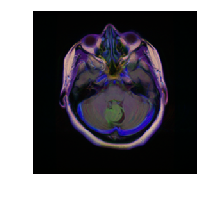

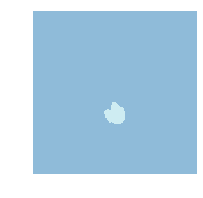

In [5]:
for f in [temp_img_file, temp_mask_file]:
    print("showing", f)
    if "_mask.tif" in f.name:
        mask = open_mask(f)
        print(mask.shape)
        mask.show()
    else:
        temp_img = open_image(f)
        print(temp_img.shape)
        temp_img.show()

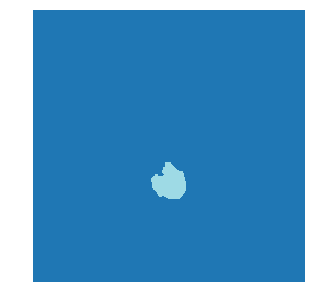

In [6]:
mask = open_mask(get_y_fn(temp_img_file), div=True)
mask.show(figsize=(5, 5), alpha=1)

In [7]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([256, 256]),
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [8]:
validation_folders = [
    "TCGA_HT_7694_19950404",
    "TCGA_DU_5874_19950510",
    "TCGA_DU_7013_19860523",
    "TCGA_HT_8113_19930809",
    "TCGA_DU_6399_19830416",
    "TCGA_HT_7684_19950816",
    "TCGA_CS_5395_19981004",
    "TCGA_FG_6688_20020215",
    "TCGA_DU_8165_19970205",
    "TCGA_DU_7019_19940908",
    "TCGA_HT_7855_19951020",
    "TCGA_DU_A5TT_19980318",
    "TCGA_DU_7300_19910814",
    "TCGA_DU_5871_19941206",
    "TCGA_DU_5855_19951217",
]

In [9]:
codes = ["n", "y"]

In [12]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
bs = free // 500
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=14, have 7369MB of GPU RAM free


In [13]:
class SegmentationLabelListWithDiv(SegmentationLabelList):
    def open(self, fn):
        return open_mask(fn, div=True)


class SegmentationItemListWithDiv(SegmentationItemList):
    _label_cls = SegmentationLabelListWithDiv

# Half size

In [14]:
src = (
    SegmentationItemListWithDiv.from_folder(data_path, recurse=True)
    .filter_by_func(lambda x: not x.name.endswith("_mask.tif"))
    .split_by_valid_func(lambda x: x.parts[-2] in validation_folders)
    .label_from_func(get_y_fn, classes=codes)
)

In [15]:
data = (
    src.transform(get_transforms(), size=src_size // 2, tfm_y=True)
    .databunch(bs=bs)
    .normalize(imagenet_stats)
)

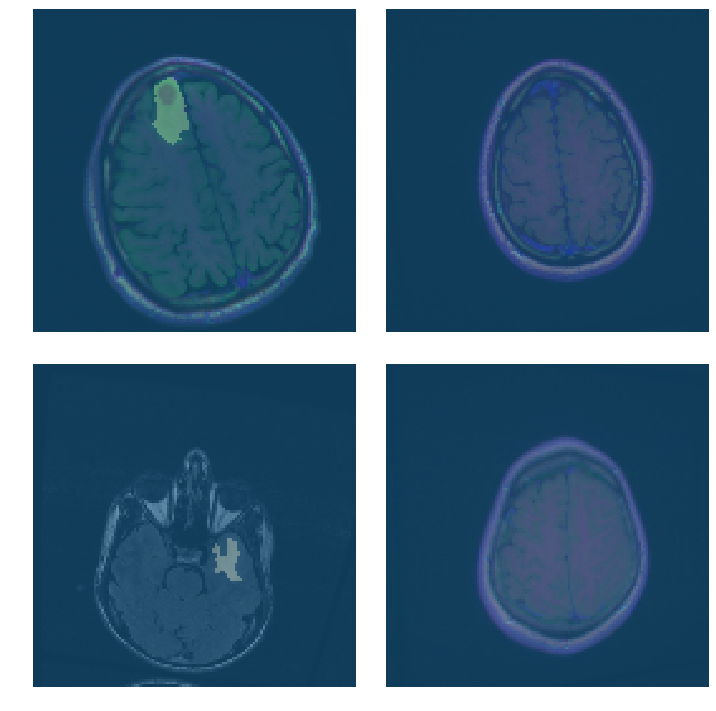

In [18]:
data.show_batch(2, figsize=(10, 10))

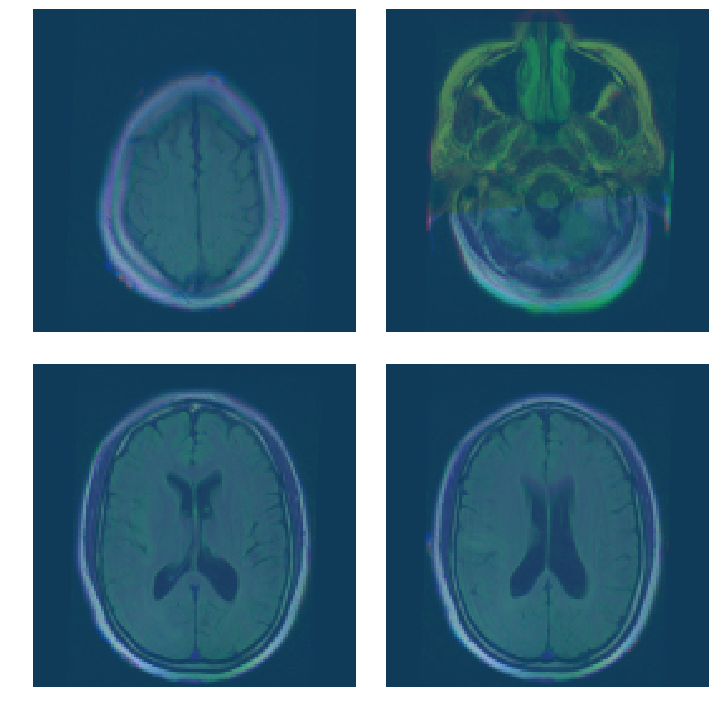

In [19]:
data.show_batch(2, figsize=(10, 10), ds_type=DatasetType.Valid)

# deeplab

In [16]:
import torch
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
from torch.nn import functional as F

In [17]:
__all__ = ["ResNet", "resnet50", "resnet101", "resnet152"]

In [18]:
model_urls = {
    "resnet50": "https://download.pytorch.org/models/resnet50-19c8e357.pth",
    "resnet101": "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth",
    "resnet152": "https://download.pytorch.org/models/resnet152-b121ed2d.pth",
}

In [44]:
class Conv2d(nn.Conv2d):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        bias=True,
    ):
        super(Conv2d, self).__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            bias,
        )

    def forward(self, x):
        # return super(Conv2d, self).forward(x)
        weight = self.weight
        weight_mean = (
            weight.mean(dim=1, keepdim=True)
            .mean(dim=2, keepdim=True)
            .mean(dim=3, keepdim=True)
        )
        weight = weight - weight_mean
        std = weight.view(weight.size(0), -1).std(dim=1).view(-1, 1, 1, 1) + 1e-5
        weight = weight / std.expand_as(weight)
        return F.conv2d(
            x, weight, self.bias, self.stride, self.padding, self.dilation, self.groups
        )

In [45]:
class ASPP(nn.Module):

    def __init__(self, C, depth, num_classes, conv=nn.Conv2d, norm=nn.BatchNorm2d, momentum=0.0003, mult=1):
        super(ASPP, self).__init__()
        self._C = C
        self._depth = depth
        self._num_classes = num_classes

        self.global_pooling = nn.AdaptiveAvgPool2d(1)
        self.relu = nn.ReLU(inplace=True)
        self.aspp1 = conv(C, depth, kernel_size=1, stride=1, bias=False)
        self.aspp2 = conv(C, depth, kernel_size=3, stride=1,
                               dilation=int(6*mult), padding=int(6*mult),
                               bias=False)
        self.aspp3 = conv(C, depth, kernel_size=3, stride=1,
                               dilation=int(12*mult), padding=int(12*mult),
                               bias=False)
        self.aspp4 = conv(C, depth, kernel_size=3, stride=1,
                               dilation=int(18*mult), padding=int(18*mult),
                               bias=False)
        self.aspp5 = conv(C, depth, kernel_size=1, stride=1, bias=False)
        self.aspp1_bn = norm(depth, momentum)
        self.aspp2_bn = norm(depth, momentum)
        self.aspp3_bn = norm(depth, momentum)
        self.aspp4_bn = norm(depth, momentum)
        self.aspp5_bn = norm(depth, momentum)
        self.conv2 = conv(depth * 5, depth, kernel_size=1, stride=1,
                               bias=False)
        self.bn2 = norm(depth, momentum)
        self.conv3 = nn.Conv2d(depth, num_classes, kernel_size=1, stride=1)

    def forward(self, x):
        x1 = self.aspp1(x)
        x1 = self.aspp1_bn(x1)
        x1 = self.relu(x1)
        x2 = self.aspp2(x)
        x2 = self.aspp2_bn(x2)
        x2 = self.relu(x2)
        x3 = self.aspp3(x)
        x3 = self.aspp3_bn(x3)
        x3 = self.relu(x3)
        x4 = self.aspp4(x)
        x4 = self.aspp4_bn(x4)
        x4 = self.relu(x4)
        x5 = self.global_pooling(x)
        x5 = self.aspp5(x5)
        x5 = self.aspp5_bn(x5)
        x5 = self.relu(x5)
        x5 = nn.Upsample((x.shape[2], x.shape[3]), mode='bilinear',
                         align_corners=True)(x5)
        x = torch.cat((x1, x2, x3, x4, x5), 1)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)

        return x

In [46]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, dilation=1, conv=None, norm=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = norm(planes)
        self.conv2 = conv(planes, planes, kernel_size=3, stride=stride,
                               dilation=dilation, padding=dilation, bias=False)
        self.bn2 = norm(planes)
        self.conv3 = conv(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = norm(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [47]:
class ResNet(nn.Module):
    def __init__(
        self, block, layers, num_classes, num_groups=None, weight_std=False, beta=False
    ):
        self.inplanes = 64
        self.norm = (
            lambda planes, momentum=0.05: nn.BatchNorm2d(planes, momentum=momentum)
            if num_groups is None
            else nn.GroupNorm(num_groups, planes)
        )
        self.conv = Conv2d if weight_std else nn.Conv2d

        super(ResNet, self).__init__()
        if not beta:
            self.conv1 = self.conv(
                3, 64, kernel_size=7, stride=2, padding=3, bias=False
            )
        else:
            self.conv1 = nn.Sequential(
                self.conv(3, 64, 3, stride=2, padding=1, bias=False),
                self.conv(64, 64, 3, stride=1, padding=1, bias=False),
                self.conv(64, 64, 3, stride=1, padding=1, bias=False),
            )
        self.bn1 = self.norm(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1, dilation=2)
        self.aspp = ASPP(
            512 * block.expansion, 256, num_classes, conv=self.conv, norm=self.norm
        )

        for m in self.modules():
            if isinstance(m, self.conv):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2.0 / n))
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.GroupNorm):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1):
        downsample = None
        if stride != 1 or dilation != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                self.conv(
                    self.inplanes,
                    planes * block.expansion,
                    kernel_size=1,
                    stride=stride,
                    dilation=max(1, dilation / 2),
                    bias=False,
                ),
                self.norm(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes,
                planes,
                stride,
                downsample,
                dilation=max(1, dilation / 2),
                conv=self.conv,
                norm=self.norm,
            )
        )
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    dilation=dilation,
                    conv=self.conv,
                    norm=self.norm,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        size = (x.shape[2], x.shape[3])
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.aspp(x)
        x = nn.Upsample(size, mode="bilinear", align_corners=True)(x)
        return x

In [48]:
def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls["resnet50"]))
    return model

In [49]:
def resnet101(pretrained=False, num_groups=None, weight_std=False, **kwargs):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(
        Bottleneck,
        [3, 4, 23, 3],
        num_groups=num_groups,
        weight_std=weight_std,
        **kwargs
    )
    if pretrained:
        model_dict = model.state_dict()
        if num_groups and weight_std:
            pretrained_dict = torch.load("data/R-101-GN-WS.pth.tar")
            overlap_dict = {
                k[7:]: v for k, v in pretrained_dict.items() if k[7:] in model_dict
            }
            assert len(overlap_dict) == 312
        elif not num_groups and not weight_std:
            pretrained_dict = model_zoo.load_url(model_urls["resnet101"])
            overlap_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        else:
            raise ValueError("Currently only support BN or GN+WS")
        model_dict.update(overlap_dict)
        model.load_state_dict(model_dict)
    return model

In [50]:
def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls["resnet152"]))
    return model

In [51]:
learn = None
gc.collect()

20001

In [52]:
from torch.optim import *

In [53]:
learn = Learner(
    data,
    resnet101(num_classes=2),
    callback_fns=[ShowGraph],
    metrics=dice,
    opt_func=AdamW,
)

epoch,train_loss,valid_loss,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


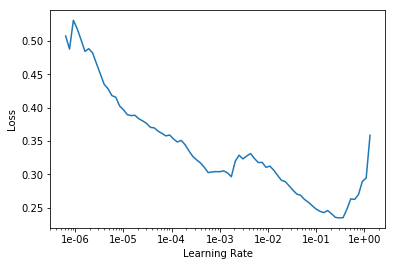

In [54]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,dice,time
0,0.326807,0.677864,0.081731,00:48
1,0.274688,0.558942,0.157678,00:49
2,0.229363,0.457402,0.210325,00:50
3,0.213518,0.359199,0.174192,00:49
4,0.205987,0.335548,0.196805,00:48
5,0.187168,0.319838,0.198950,00:49
6,0.180457,0.264868,0.196401,00:48
7,0.174136,0.239341,0.188926,00:48


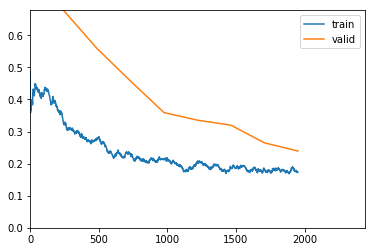

KeyboardInterrupt: 

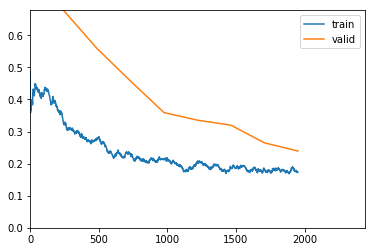

In [57]:
learn.fit_one_cycle(10, max_lr=slice(1e-6), wd=10e-4)

epoch,train_loss,valid_loss,dice,time
0,0.042592,0.417564,0.083472,00:27
1,0.046368,0.179589,0.210428,00:27
2,0.056034,0.148946,0.222350,00:28
3,0.031931,0.108784,0.349626,00:27
4,0.031074,0.052411,0.561679,00:27
5,0.027141,0.063126,0.553885,00:27
6,0.024037,0.060195,0.556755,00:27
7,0.020859,0.044898,0.616341,00:26
8,0.022918,0.043997,0.627805,00:26
9,0.021517,0.039800,0.659902,00:26


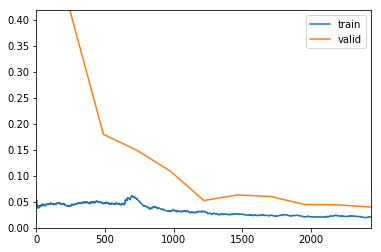

In [86]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-4), wd=1e-4)

epoch,train_loss,valid_loss,dice,time
0,0.022448,0.028567,0.691344,00:26
1,0.026478,0.030891,0.696046,00:27
2,0.029428,0.050277,0.612113,00:27
3,0.024705,0.026549,0.728218,00:27
4,0.019154,0.022123,0.715813,00:27
5,0.018118,0.022996,0.745296,00:26
6,0.016841,0.021195,0.739956,00:27
7,0.015815,0.018518,0.764817,00:27
8,0.015089,0.016862,0.779990,00:27
9,0.015118,0.016428,0.787958,00:27


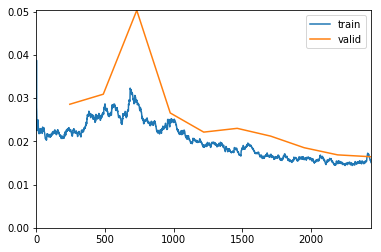

In [87]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-4), wd=1e-4)

In [88]:
learn.save("stage-1")

epoch,train_loss,valid_loss,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


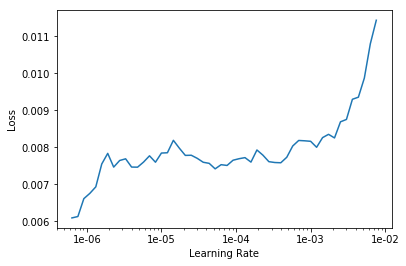

In [98]:
learn.unfreeze()
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,dice,time
0,0.014649,0.017010,0.769624,00:27
1,0.018150,0.016597,0.785793,00:27
2,0.018622,0.019878,0.774627,00:27
3,0.016393,0.014854,0.792259,00:27
4,0.014787,0.013541,0.800713,00:27
5,0.013264,0.012949,0.827152,00:27
6,0.012925,0.012574,0.837309,00:27
7,0.011969,0.012054,0.829395,00:27
8,0.012000,0.011945,0.822858,00:27
9,0.011832,0.011903,0.822785,00:27


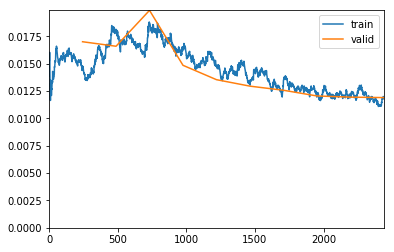

In [90]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(9e-5), wd=1e-4)

epoch,train_loss,valid_loss,dice,time
0,0.012220,0.011544,0.830699,00:27
1,0.014453,0.015133,0.795734,00:27
2,0.014074,0.012439,0.839910,00:27
3,0.013309,0.012145,0.825242,00:27
4,0.013333,0.012883,0.832583,00:28
5,0.012579,0.012311,0.825377,00:27
6,0.012058,0.011605,0.841012,00:27
7,0.011445,0.011144,0.838459,00:27
8,0.010631,0.010982,0.848878,00:27
9,0.011322,0.010845,0.848760,00:27


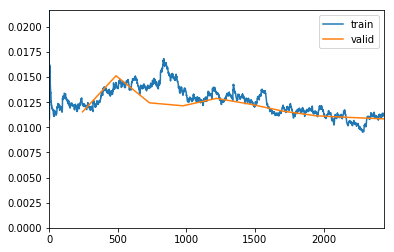

In [91]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(9e-5), wd=1e-4)

epoch,train_loss,valid_loss,dice,time
0,0.011266,0.012360,0.820726,00:27
1,0.017534,0.026843,0.656955,00:27
2,0.028436,0.301149,0.474729,00:27
3,0.018495,0.039999,0.514945,00:27
4,0.016254,0.026578,0.733315,00:28
5,0.015226,0.020036,0.750122,00:27
6,0.015464,0.017733,0.781207,00:27
7,0.012404,0.015807,0.795666,00:27
8,0.011993,0.013590,0.824613,00:27
9,0.012531,0.013262,0.824689,00:27


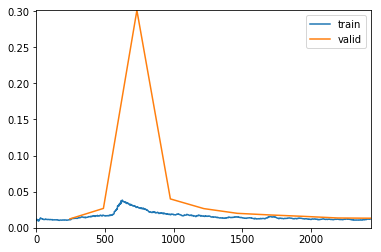

In [93]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(3e-4), wd=1e-4)

In [97]:
learn.save("stage-2")

epoch,train_loss,valid_loss,dice,time
0,0.011077,0.012732,0.831692,00:28
1,0.012004,0.012173,0.834244,00:26
2,0.011741,0.012051,0.831619,00:27
3,0.011638,0.011437,0.835653,00:27
4,0.012431,0.012177,0.818503,00:27
5,0.012206,0.012867,0.833363,00:27
6,0.012128,0.014258,0.821243,00:27
7,0.015631,0.017433,0.775568,00:27
8,0.012834,0.013207,0.778342,00:27
9,0.014097,0.012820,0.823123,00:27


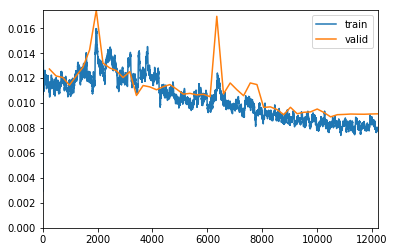

In [95]:
learn.unfreeze()
learn.fit_one_cycle(50, slice(3e-4), wd=1e-2)

epoch,train_loss,valid_loss,dice,time
0,0.008023,0.009253,0.865827,00:27
1,0.008154,0.009348,0.868095,00:27
2,0.008762,0.009070,0.872224,00:27
3,0.008414,0.009641,0.865595,00:27
4,0.008629,0.009218,0.871444,00:27
5,0.008185,0.009613,0.854782,00:27
6,0.008324,0.009827,0.862257,00:27
7,0.009415,0.009408,0.859208,00:27
8,0.008966,0.011082,0.859516,00:27
9,0.011635,0.011138,0.864940,00:27


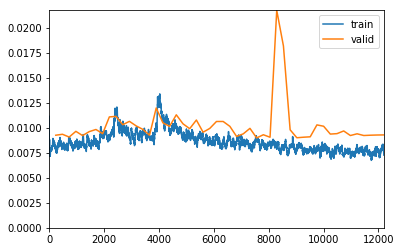

In [96]:
learn.unfreeze()
learn.fit_one_cycle(50, slice(3e-4), wd=1e-2)

epoch,train_loss,valid_loss,dice,time
0,0.007468,0.009317,0.868432,00:26
1,0.007542,0.009300,0.866534,00:27
2,0.007271,0.009279,0.869321,00:27
3,0.007502,0.009459,0.868687,00:27
4,0.007768,0.009539,0.866562,00:27
5,0.007411,0.009397,0.867521,00:27
6,0.007439,0.009240,0.866795,00:27
7,0.007763,0.009335,0.868100,00:27
8,0.007052,0.009230,0.866269,00:27
9,0.007223,0.009314,0.867656,00:27


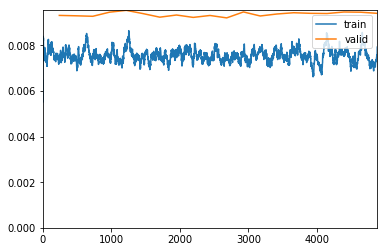

In [99]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-5), wd=1e-2)

In [100]:
learn.save("stage-3")

# Full size

In [101]:
learn = None
gc.collect()

18096

In [102]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
bs = free // 500
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=11, have 5575MB of GPU RAM free


In [103]:
class SegmentationLabelListWithDiv(SegmentationLabelList):
    def open(self, fn):
        return open_mask(fn, div=True)


class SegmentationItemListWithDiv(SegmentationItemList):
    _label_cls = SegmentationLabelListWithDiv

In [104]:
src = (
    SegmentationItemListWithDiv.from_folder(data_path, recurse=True)
    .filter_by_func(lambda x: not x.name.endswith("_mask.tif"))
    .split_by_valid_func(lambda x: x.parts[-2] in validation_folders)
    .label_from_func(get_y_fn, classes=codes)
)

In [105]:
data = (
    src.transform(get_transforms(), size=src_size, tfm_y=True)
    .databunch(bs=bs)
    .normalize(imagenet_stats)
)

In [106]:
learn = Learner(
    data,
    resnet50(num_classes=2),
    callback_fns=[ShowGraph],
    metrics=dice,
    opt_func=AdamW,
)

In [108]:
learn.load("stage-3")
;

epoch,train_loss,valid_loss,dice,time
0,0.014940,0.021300,0.766847,01:23
1,0.008796,0.011502,0.846715,01:24
2,0.008125,0.010000,0.870393,01:24
3,0.007928,0.008889,0.883062,01:24
4,0.007011,0.008085,0.890380,01:25
5,0.006509,0.008468,0.890226,01:25
6,0.006834,0.008636,0.887614,01:26
7,0.007013,0.007897,0.897160,01:25
8,0.006658,0.007914,0.896360,01:24
9,0.006896,0.007939,0.897182,01:22


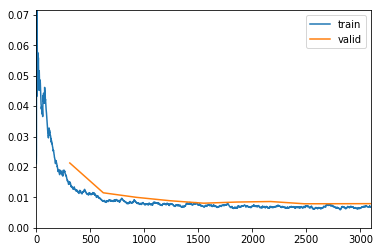

In [110]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-4), wd=10e-4)

epoch,train_loss,valid_loss,dice,time
0,0.006778,0.007544,0.902152,01:23
1,0.007106,0.008500,0.892781,01:22
2,0.007440,0.007882,0.889656,01:23
3,0.007094,0.007910,0.882719,01:23
4,0.006255,0.007191,0.904582,01:24
5,0.006245,0.007840,0.897421,01:24
6,0.006590,0.007027,0.898562,01:23
7,0.006349,0.007412,0.897316,01:23
8,0.006004,0.007208,0.896267,01:23
9,0.006586,0.007328,0.896429,01:24


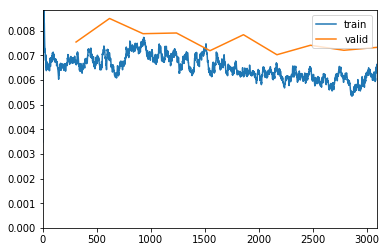

In [113]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-4), wd=10e-4)

epoch,train_loss,valid_loss,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


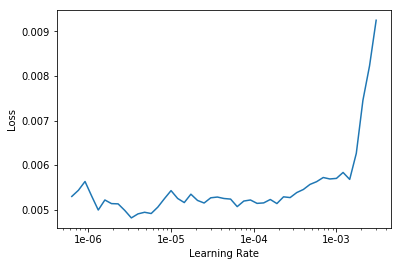

In [121]:
learn.unfreeze()
lr_find(learn)
learn.recorder.plot()

In [115]:
learn.save("stage-1")

In [118]:
learn.load("stage-1")
;

epoch,train_loss,valid_loss,dice,time
0,0.006103,0.007320,0.896417,01:24
1,0.006650,0.010564,0.844688,01:23
2,0.006359,0.009231,0.891677,01:22
3,0.006314,0.007417,0.894594,01:22
4,0.006713,0.007157,0.888841,01:25
5,0.006496,0.007747,0.894684,01:25
6,0.005863,0.008392,0.891447,01:23
7,0.005648,0.007544,0.894855,01:22
8,0.005679,0.007599,0.897466,01:24
9,0.005800,0.007487,0.897731,01:22


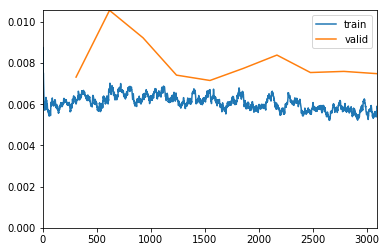

In [119]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-4, wd=1e-4)

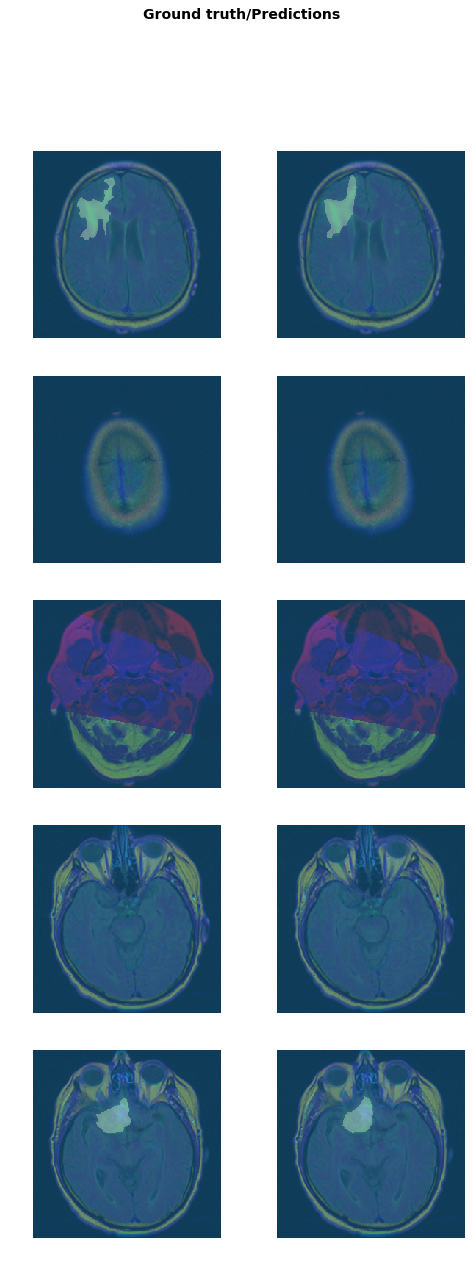

In [120]:
learn.show_results(10)

epoch,train_loss,valid_loss,dice,time
0,0.005400,0.007491,0.896750,01:22
1,0.006102,0.007325,0.901825,01:23
2,0.005794,0.008817,0.894279,01:23
3,0.005900,0.009542,0.888875,01:23
4,0.005959,0.009240,0.887661,01:24
5,0.005791,0.006913,0.903482,01:25
6,0.005836,0.007693,0.893165,01:26
7,0.005580,0.007356,0.900235,01:23
8,0.005241,0.007638,0.899201,01:22
9,0.005154,0.007594,0.900229,01:24


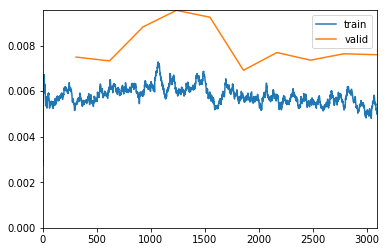

In [122]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=1e-4, wd=1e-2)